In [1]:
# imports:  
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0);
import pandas as pd

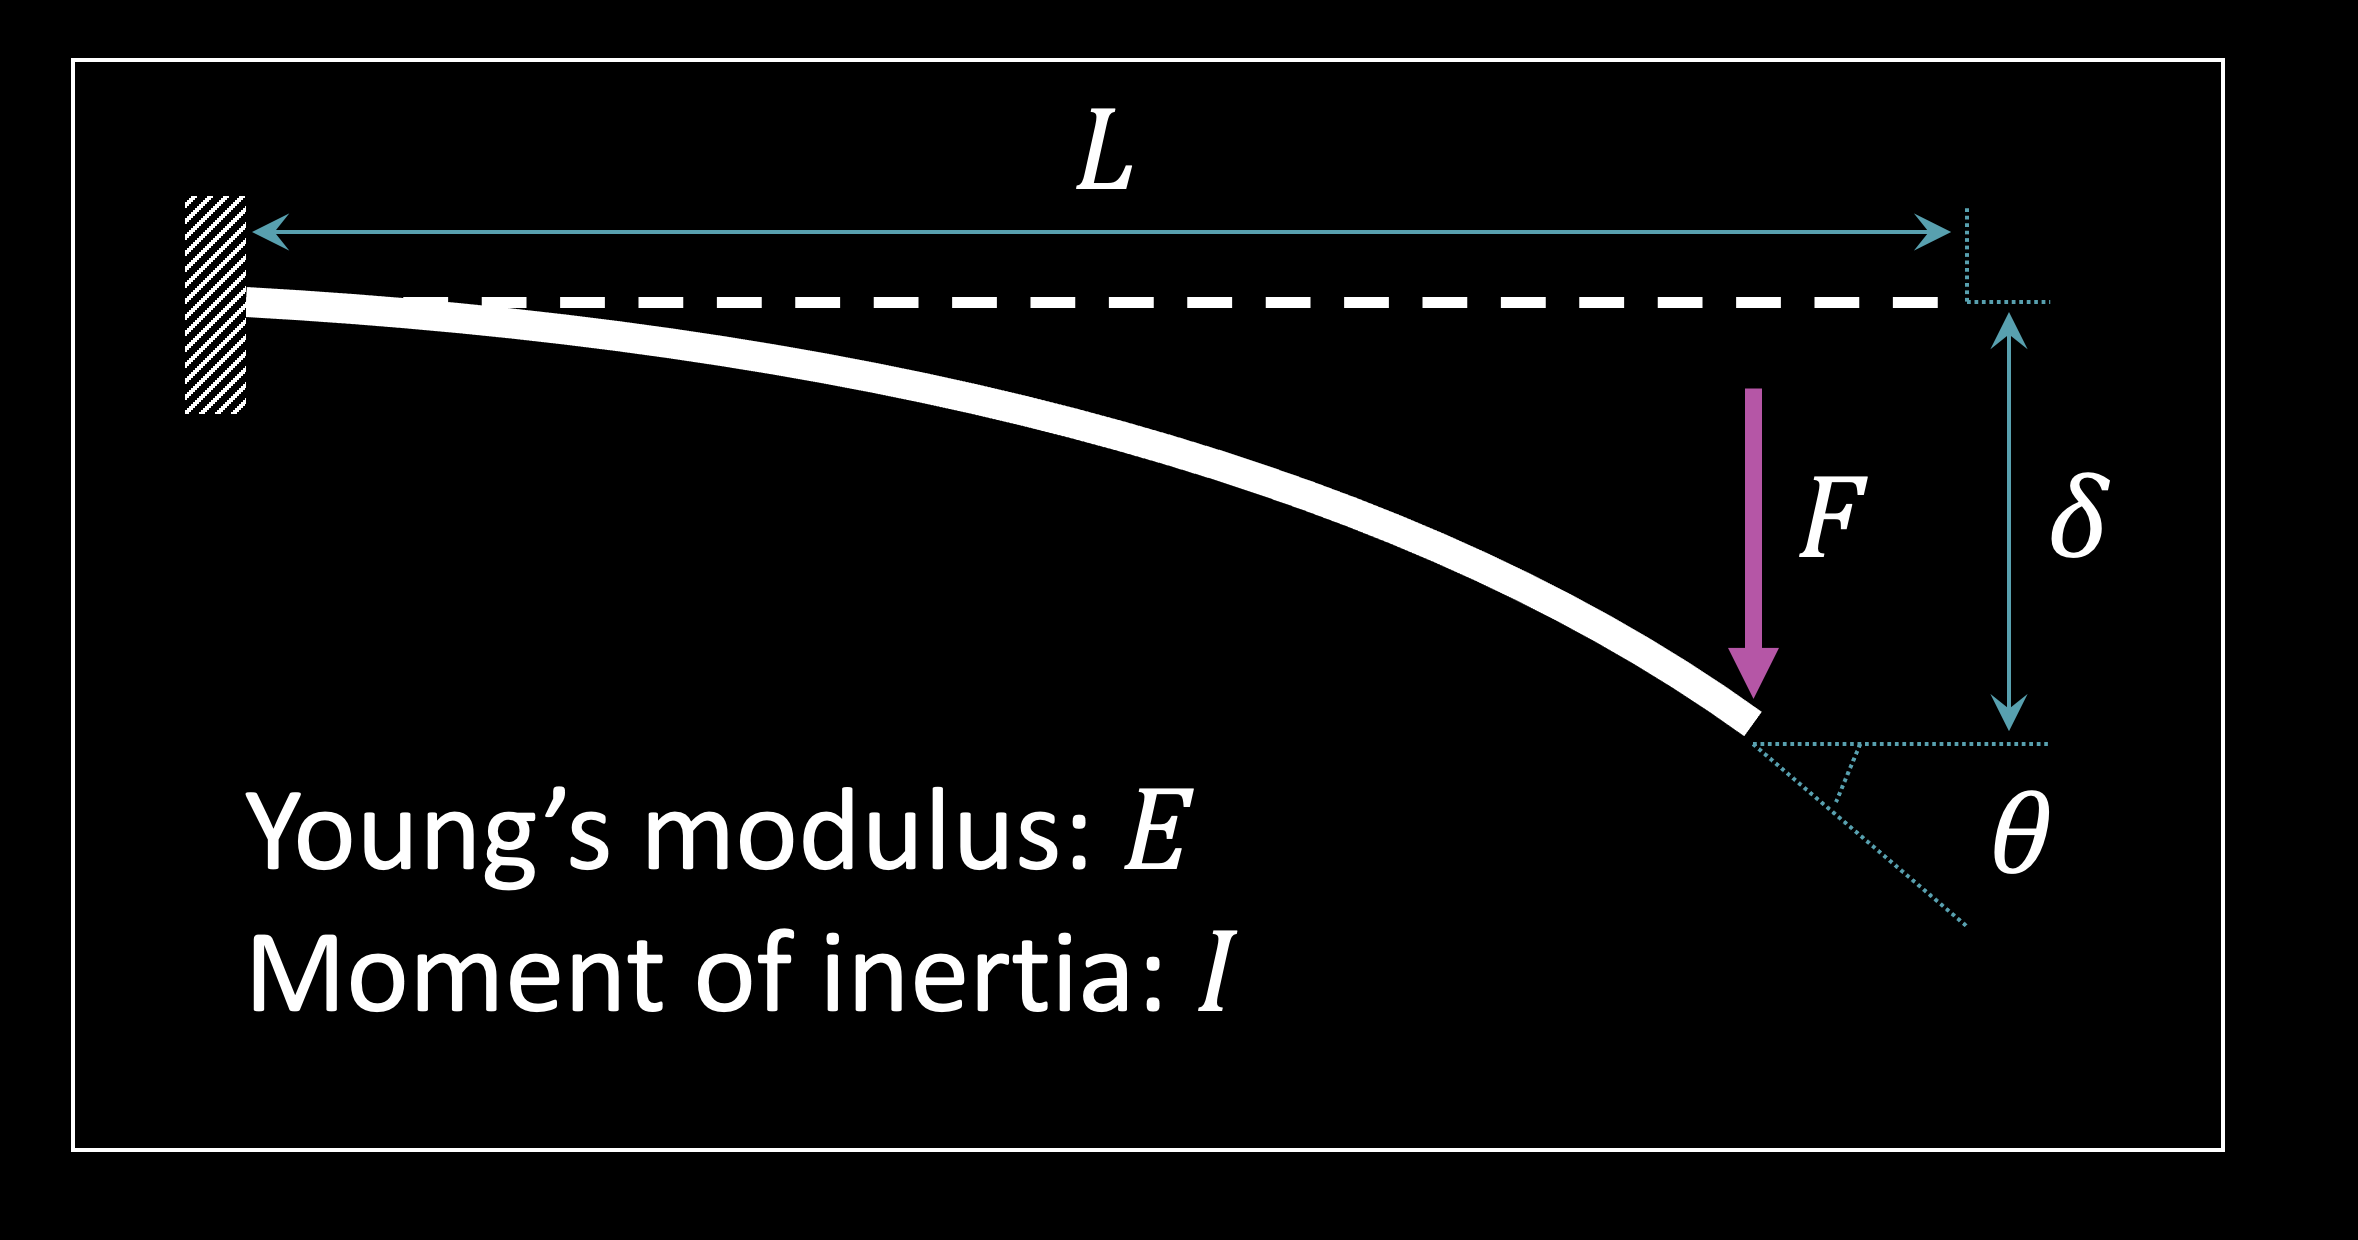

### Input: 
$F\ [\text{N}], L\ [\text{m}], E\ [\text{GPa}], I\ [\text{cm}^4]$

### Output: 
$\delta\ [\text{mm}], \theta\ [^\circ]$

### Task: Train a NN on the given data using proper normalizations. Fill To-do's.

In [2]:
# Load data from .csv file using pandas (Review the code yourself)

df = pd.read_csv('data-3AB-train.csv')
x_train = torch.tensor(df[['F','L','E','I']].astype(np.float32).values)
y_train = torch.tensor(df[['delta','theta']].astype(np.float32).values)

df = pd.read_csv('data-3AB-test.csv')
x_test = torch.tensor(df[['F','L','E','I']].astype(np.float32).values)
y_test = torch.tensor(df[['delta','theta']].astype(np.float32).values)

In [3]:
print(x_train)
print(y_train)

tensor([[4.3320e+03, 9.7436e+00, 1.4963e+02, 1.3770e+04],
        [3.7687e+03, 7.8370e+00, 1.7682e+02, 7.4727e+03],
        [3.7289e+03, 1.0387e+01, 1.0885e+02, 6.6406e+03],
        ...,
        [3.0583e+03, 6.2898e+00, 1.5196e+02, 6.2782e+03],
        [3.3618e+03, 8.6725e+00, 1.3481e+02, 1.3412e+04],
        [4.8272e+03, 7.9596e+00, 1.8767e+02, 5.5262e+03]])
tensor([[ 64.8350,   0.5719],
        [ 45.7624,   0.5018],
        [192.7390,   1.5947],
        ...,
        [ 26.5895,   0.3633],
        [ 40.4257,   0.4006],
        [ 78.2389,   0.8448]])


## Visualize your data!

In [4]:
# Check x-data shape
x_train.shape

torch.Size([2000, 4])

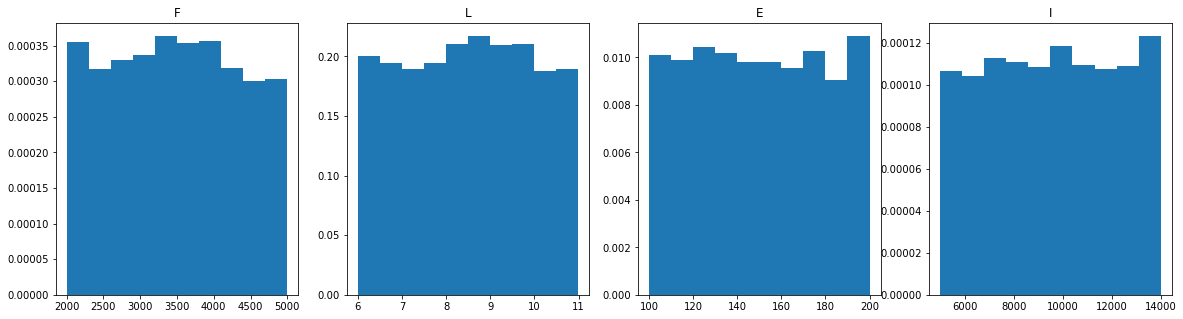

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].hist(x_train[:,0].detach().numpy(),density=True); axes[0].set_title('F');
axes[1].hist(x_train[:,1].detach().numpy(),density=True); axes[1].set_title('L');
axes[2].hist(x_train[:,2].detach().numpy(),density=True); axes[2].set_title('E');
axes[3].hist(x_train[:,3].detach().numpy(),density=True); axes[3].set_title('I');

In [6]:
# Check y-data shape
y_train.shape

torch.Size([2000, 2])

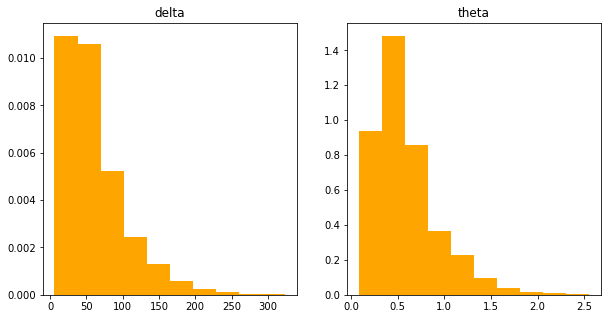

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(y_train[:,0].detach().numpy(),density=True,color='orange'); axes[0].set_title('delta');
axes[1].hist(y_train[:,1].detach().numpy(),density=True,color='orange'); axes[1].set_title('theta');

## Normalize your data


In [8]:
class Normalization:
    def __init__(self,data):
        
        # empty list of min and max values of each column
        self.min_values = []
        self.max_values = []
        
        # find min and max of each column and store in lists
        for i in range(data.shape[1]):
            self.min_values.append(torch.min(data[:,i]))
            self.max_values.append(torch.max(data[:,i]))
        
    def normalize(self, data):
        
        # clone the data before modification
        normalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # normalize each column between values 0 and 1 range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            normalized_data[:,i] = (data[:,i]-a)/b
        
        # return
        return normalized_data
    
    def unnormalize(self, data):
        
        # clone the data before modification
        unnormalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):            
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # unnormalize each column to original range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            unnormalized_data[:,i] = a + b*data[:,i]          
            
        # return
        return unnormalized_data


In [9]:
# Always use TRAINING DATA ONLY for identifying min and max values for normalization
# Careful: you'll need two different normalization for x and y
x_normalization = Normalization(x_train)
y_normalization = Normalization(y_train)

# Normalize both training and test data
x_train = x_normalization.normalize(x_train)
x_test = x_normalization.normalize(x_test)

y_train = y_normalization.normalize(y_train)
y_test = y_normalization.normalize(y_test)

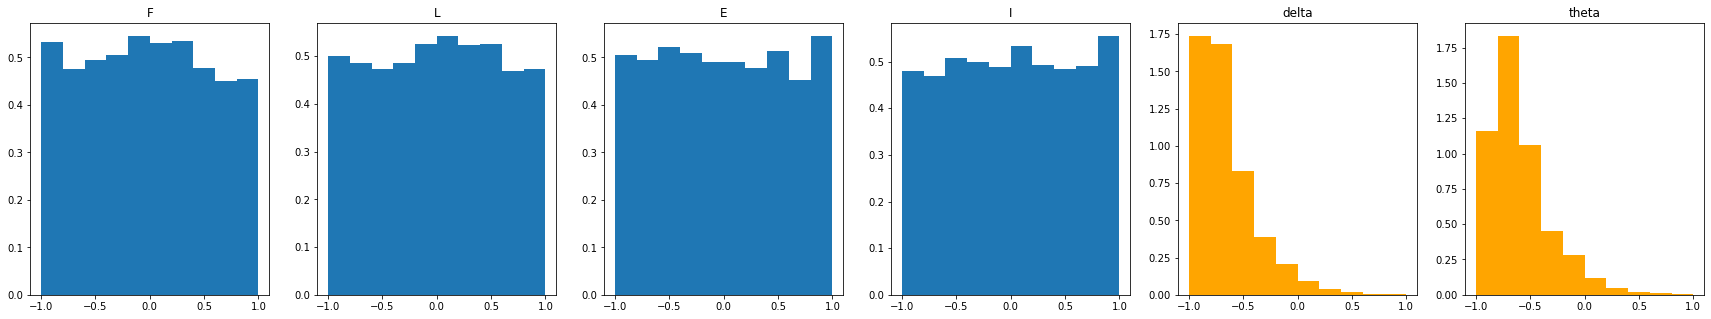

In [10]:
# Visualize the normalized data
fig, axes = plt.subplots(1, 6, figsize=(30, 5))
axes[0].hist(x_train[:,0].detach().numpy(),density=True); axes[0].set_title('F');
axes[1].hist(x_train[:,1].detach().numpy(),density=True); axes[1].set_title('L');
axes[2].hist(x_train[:,2].detach().numpy(),density=True); axes[2].set_title('E');
axes[3].hist(x_train[:,3].detach().numpy(),density=True); axes[3].set_title('I');
axes[4].hist(y_train[:,0].detach().numpy(),density=True,color='orange'); axes[4].set_title('delta');
axes[5].hist(y_train[:,1].detach().numpy(),density=True,color='orange'); axes[5].set_title('theta');

In [11]:
# Create a NN model
nn = torch.nn.Sequential(
    torch.nn.Linear(4,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,2)
)

# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.01

# Optimizer: use Adam
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# Number of epochs
num_epochs = 5000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = nn(x_train)
    
    # Compute the loss. 
    train_loss = loss_function(y_train_pred, y_train)
    
    
    # store the loss in a list
    train_loss_history.append(train_loss.detach().item())
    
    
    # Call .backward() on loss to compute gradient (d_loss/d_a)
    train_loss.backward()
    
    # Update the model paramaeters
    # No need for torch.no_grad() anymore with in-built optimizers
    optimizer.step()
    
    # remove any pre-exisitng gradients stored
    optimizer.zero_grad()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad(): #torch.no_grad() is back because we don't train on test data and so don't need gradients
        
        # Make your predictions
        y_test_pred = nn(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        
        # store the loss in a list
        test_loss_history.append(test_loss.detach().item())

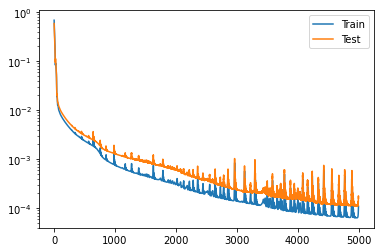

In [12]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test'])

In [13]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)


def plotR2(true, pred):
    dim = true.shape[1]
    fig = plt.figure(figsize=plt.figaspect(1./dim))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([true[:,index].min(),true[:,index].max()],[true[:,index].min(),true[:,index].max()],c='red')
        ax.set_title('Label dim: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(dim):
        ax = fig.add_subplot(1, dim, i+1); helper(ax,i)
    fig.tight_layout()

In [14]:
with torch.no_grad():
    # Make prediction on test set
    y_test_pred = nn(x_test)

In [15]:
# Unnormalize all y-data
# To-do
y_train = y_normalization.unnormalize(y_train)
y_test = y_normalization.unnormalize(y_test)
y_test_pred = y_normalization.unnormalize(y_test_pred)

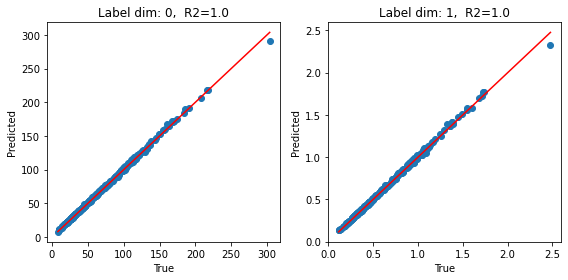

In [16]:
# Visualize accuracy
plotR2(y_test, y_test_pred)